# Entrega Final - Núcleo de Finanças - Trainees

# De: Lucas Pimentel e João Casella

==================================================================================================================

#A modelagem escolhida foi por Trend Following das empresas AgroGalaxy e Boa Safra. Decidiu-se utilizar:
#O método MACD para a identificação de tendências;
#O método RSI para interpretar o momentum dessas tendências;
#E o método ADX, como veredito, para se compreender a força das tendências e optar-se pela compra ou venda do ativo.
#Foram simulados os desempenhos de cada ativo para com a estratégia de índices técnicos, com um output na segunda parte do código

#Para a primeira parte do código, tem-se a definição dos objetos essenciais para a realização do backtesting. Optou-se por colocá-los diretamente no código e não importá-los para evitar erros.
#A segunda parte contém a aplicação do modelo e gráficos para compreensão dos resultados das simulações.

===================================================================================================================

In [1]:
#Bibliotecas utilizadas

%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import random
import pandas_ta as ta
import yahoofinancials as yf
from copy import deepcopy

# Parte 1: Classes/objetos para o backtesting 
(arquivo backtesting da eletiva Algotrading)

In [2]:
def sign(number):
    if number > 0:
        return 1
    elif number < 0:
        return -1
    return 0
class Event():

    BID, ASK, TRADE, CANDLE = ['BID', 'ASK', 'TRADE', 'CANDLE']

    def __init__(self, instrument, timestamp, type, price, quantity):
        self.instrument = instrument
        self.timestamp = timestamp
        self.type = type
        self.price = price
        self.quantity = quantity

In [3]:
class Order():

    id = 0

    NEW, PARTIAL, FILLED, REJECTED, CANCELED = [
        'NEW', 'PARTIAL', 'FILLED', 'REJECTED', 'CANCELED']

    @staticmethod
    def nextId():
        Order.id += 1
        return Order.id

    def __init__(self, instrument, quantity, price):
        self.id = Order.nextId()
        self.owner = 0
        self.instrument = instrument
        self.status = Order.NEW
        self.timestamp = ''
        self.quantity = quantity
        self.price = price
        self.executed = 0
        self.average = 0

    def print(self):
        return '{0} - {1} - {5}: {2}/{3}@{4}'.format(self.id, self.timestamp, self.executed, self.quantity, self.price, self.instrument)

In [4]:
class MarketData():

    TICK, HIST, INTR = ['TICK', 'HIST', 'INTR']

    def __init__(self):

        self.events = {}

    def loadBBGTick(self, file, instrument):

        with open(file, 'r') as file:
            data = file.read()

        events = data.split('\n')
        events = events[1:]
        for event in events:
            cols = event.split(';')
            if len(cols) == 4:
                date = datetime.strptime(cols[0], '%d/%m/%Y %H:%M:%S')
                price = float(cols[2].replace(',', '.'))
                quantity = int(cols[3])
                type = cols[1]

                if date.toordinal() not in self.events:
                    self.events[date.toordinal()] = []

                self.events[date.toordinal()].append(
                    Event(instrument, date, type, price, quantity))

    def loadYAHOOHist(self, file, instrument, type=Event.CANDLE):

        with open(file, 'r') as file:
            data = file.read()

        events = data.split('\n')
        events = events[1:]
        for event in events:
            cols = event.split(',')
            if len(cols) == 7 and cols[1] != 'null':

                date = datetime.strptime(cols[0], '%Y-%m-%d')
                price = (float(cols[1]), float(cols[2]),
                         float(cols[3]), float(cols[4]))
                quantity = 0 # float(cols[6])

                if date.toordinal() not in self.events:
                    self.events[date.toordinal()] = []

                self.events[date.toordinal()].append(
                    Event(instrument, date, type, price, quantity))

    def loadBBGIntr(self, file, instrument, type=Event.CANDLE):

        with open(file, 'r') as file:
            data = file.read()

        events = data.split('\n')
        events = events[1:]
        for event in events:
            cols = event.split(';')
            if len(cols) == 5:

                date = datetime.strptime(cols[0], '%d/%m/%Y %H:%M:%S')
                price = (float(cols[1].replace(',', '.')),
                         float(cols[3].replace(',', '.')),
                         float(cols[4].replace(',', '.')),
                         float(cols[2].replace(',', '.')))
                quantity = 0

                if date.timestamp() not in self.events:
                    self.events[date.timestamp()] = []

                self.events[date.timestamp()].append(
                    Event(instrument, date, type, price, quantity))

    def run(self, ts):
        dates = list(self.events.keys())
        dates.sort()
        for date in dates:
            for event in self.events[date]:
                ts.inject(event)

In [5]:
class Strategy():

    id = 0

    @staticmethod
    def nextId():
        Strategy.id += 1
        return Strategy.id

    def __init__(self):
        pass

    def clear(self):
        self._id = Strategy.nextId()

        self._position = {}
        self._last = {}

        self._legs = []

        self._result = {}
        self._notional = {}

        self._orders = []

    def cancel(self, owner, id):
        pass

    def submit(self, id, orders):
        pass

    def event(self, event):

        self._last[event.instrument] = event.price
        return self.push(event)

    def push(self, event):
        pass

    def _fill(self, id, instrument, price, quantity, status):

        if price != 0:

            if instrument not in self._position:
                self._position[instrument] = 0

            if instrument not in self._result:
                self._result[instrument] = 0

            if instrument not in self._notional:
                self._notional[instrument] = 0

            self._position[instrument] += quantity
            self._result[instrument] -= quantity*price

            if quantity > 0:
                self._notional[instrument] += quantity*price
            else:
                self._notional[instrument] -= quantity*price

            if self.zeroed():
                self._legs.append((self.totalResult(), self.totalNotional()))
            
            self.fill(id, instrument, price, quantity, status)
                
    def fill(self, id, instrument, price, quantity, status):
        pass

    def zeroed(self):
        for position in self._position.values():
            if position != 0:
                return False
        return True

    def close(self):

        orders = []
        for instrument, position in self._position.items():
            if position != 0:
                orders.append(Order(instrument, -position, 0))

        return orders

    def partialResult(self):
        res = {}
        for instrument, result in self._result.items():
            res[instrument] = result + \
                self._position[instrument]*self._last[instrument]
        return res

    def totalNotional(self):
        res = 0
        for notional in self._notional.values():
            res += notional
        return res

    def totalResult(self):
        res = 0
        for result in self._result.values():
            res += result
        return res

    def summary(self, tax=0.00024, fee=0):

        # Number of trades
        nt = len(self._legs)

        # Hitting ratio
        hr = 0

        # P&L
        pnl = 0

        # Accumulated Return
        ret = 0

        net = 0
        avg = 0
        mp = -float("inf")
        md = float("inf")
        amo = 0
        if nt > 0:
            pnl = self._legs[-1][0]

            amo = self._legs[-1][1]
            ret = pnl / (amo/2)

            if pnl > 0:
                hr += 1

            mp = self._legs[0][0]
            md = self._legs[0][0]

            avg = self._legs[0][0]/(self._legs[0][1]/2)

            i = 1
            while i < len(self._legs):
                res = self._legs[i][0]-self._legs[i-1][0]
                amo = (self._legs[i][1]-self._legs[i-1][1])/2
                avg += res/amo

                if res > mp:
                    mp = res
                if res < md:
                    md = res

                if res > 0:
                    hr += 1

                i += 1

            avg = avg/nt
            hr = hr/nt

        res = ''
        res += 'Number of trades: {0}\n'.format(nt)
        res += 'Gross P&L: {0:.2f}\n'.format(pnl)
        res += 'Gross Accumulated return: {0:.2f}%\n'.format(100 * ret)
        res += 'Gross Average Return: {0:.2f}%\n'.format(100 * avg)

        net = pnl - amo * tax - nt * fee
        res += 'Net P&L: {0:.2f}\n'.format(net)

        res += 'Hitting ratio: {0:.2f}%\n'.format(100*hr)
        res += 'Max Profit: {0:.2f}\n'.format(mp)
        res += 'Max Drawdown: {0:.2f}\n'.format(md)

        return res

In [6]:
class Book():

    def __init__(self, instrument, fill):

        self.instrument = instrument
        self.fill = fill

        # market data
        self.bid = None
        self.ask = None
        self.trade = None
        self.timestamp = None

        self.orders = []

    def inject(self, event):
        if event.instrument == self.instrument:
            self.timestamp = event.timestamp

            if event.type == Event.CANDLE:
                event.price = event.price[3]

            if event.type == Event.BID or event.type == Event.CANDLE:
                self.bid = event
                for order in self.orders:
                    if order.quantity < 0:
                        if order.price <= event.price:
                            rem = order.quantity - order.executed

                            if event.quantity == 0:
                                qty = rem
                            else:
                                qty = max(rem, -event.quantity)

                            average = order.average * order.executed + qty * event.price

                            order.executed += qty
                            order.average = average / order.executed

                            if order.quantity == order.executed:
                                order.status = Order.FILLED

                            self.fill(order.id, event.price, qty, order.status)

            if event.type == Event.ASK or event.type == Event.CANDLE:
                self.ask = event
                for order in self.orders:
                    if order.quantity > 0:
                        if order.price >= event.price:
                            rem = order.quantity - order.executed

                            if event.quantity == 0:
                                qty = rem
                            else:
                                qty = min(rem, event.quantity)

                            average = order.average * order.executed + qty * event.price

                            order.executed += qty
                            order.average = average / order.executed

                            if order.quantity == order.executed:
                                order.status = Order.FILLED

                            self.fill(order.id, event.price, qty, order.status)

            if event.type == Event.TRADE:
                self.trade = event
                for order in self.orders:
                    if order.quantity > 0 and order.price >= event.price:
                        rem = order.quantity - order.executed

                        if event.quantity == 0:
                            qty = rem
                        else:
                            qty = min(rem, event.quantity)

                        average = order.average * order.executed + qty * event.price

                        order.executed += qty
                        order.average = average / order.executed

                        if order.quantity == order.executed:
                            order.status = Order.FILLED

                        self.fill(order.id, event.price, qty, order.status)

                    if order.quantity < 0 and order.price <= event.price:
                        rem = order.quantity - order.executed

                        if event.quantity == 0:
                            qty = rem
                        else:
                            qty = max(rem, -event.quantity)

                        average = order.average * order.executed + qty * event.price

                        order.executed += qty
                        order.average = average / order.executed

                        if order.quantity == order.executed:
                            order.status = Order.FILLED

                        self.fill(order.id, event.price, qty, order.status)

            i = 0
            while i < len(self.orders):
                if self.orders[i].status == Order.FILLED:
                    del self.orders[i]
                else:
                    i += 1

    def submit(self, order):
        if order is not None:
            if order.price == 0:  # MKT
                if order.quantity > 0:
                    if self.ask.quantity == 0:
                        order.executed = order.quantity
                    else:
                        order.executed = min(
                            [self.ask.quantity, order.quantity])

                    order.average = self.ask.price
                    order.status = Order.FILLED

                    self.fill(order.id, order.average,
                              order.executed, order.status)

                elif order.quantity < 0:
                    if self.bid.quantity == 0:
                        order.executed = order.quantity
                    else:
                        order.executed = max(
                            [-self.bid.quantity, order.quantity])

                    order.average = self.bid.price
                    order.status = Order.FILLED

                    self.fill(order.id, order.average,
                              order.executed, order.status)

            else:  # LMT order
                if self.ask is not None and order.quantity > 0 and order.price >= self.ask.price:
                    if self.ask.quantity == 0:
                        order.executed = order.quantity
                        order.average = self.ask.price
                        order.status = Order.FILLED
                    else:
                        order.executed = min(
                            [self.ask.quantity, order.quantity])
                        order.average = self.ask.price
                        if order.executed == order.quantity:
                            order.status = Order.FILLED
                        else:
                            order.status = Order.PARTIAL
                            self.orders.append(order)
                    self.fill(order.id, order.average,
                              order.executed, order.status)
                elif self.bid is not None and order.quantity < 0 and order.price <= self.bid.price:
                    if self.bid.quantity == 0:
                        order.executed = order.quantity
                        order.average = self.bid.price
                        order.status = Order.FILLED
                    else:
                        order.executed = max(
                            [-self.bid.quantity, order.quantity])
                        order.average = self.bid.price
                        if order.executed == order.quantity:
                            order.status = Order.FILLED
                        else:
                            order.status = Order.PARTIAL
                            self.orders.append(order)
                    self.fill(order.id, order.average,
                              order.executed, order.status)
                elif order.quantity != 0:
                    self.orders.append(order)

    def cancel(self, id):
        i = 0
        while i < len(self.orders):
            if self.orders[i].id == id:
                order = self.orders[i]
                del self.orders[i]
                order.status = Order.CANCELED
                self.fill(order.id, 0, 0, order.status)
                i = len(self.orders)
            else:
                i += 1


In [7]:
class TradingSystem():

    def __init__(self):
        self.books = {}
        self.position = {}
        self.orders = {}
        self.listeners = {}
        self.strategies = {}

    def createBook(self, instrument):
        if instrument not in self.books:
            self.books[instrument] = Book(instrument, self.fill)

        if instrument not in self.position:
            self.position[instrument] = {}

        if instrument not in self.listeners:
            self.listeners[instrument] = []

    def inject(self, event):
        instrument = event.instrument
        if instrument in self.books:
            self.books[instrument].inject(deepcopy(event))

            for id in self.listeners[instrument]:
                if id in self.strategies:
                    self.submit(id, self.strategies[id].event(event))

    def subscribe(self, instrument, strategy):
        if strategy.id not in self.strategies:
            self.strategies[strategy.id] = strategy
            strategy.cancel = self.cancel
            strategy.submit = self.submit

        if instrument in self.books:
            if strategy.id not in self.position[instrument]:
                self.position[instrument][strategy.id] = 0

            if strategy.id not in self.listeners[instrument]:
                self.listeners[instrument].append(strategy.id)

    def submit(self, id, orders):
        if orders is None:
            orders = []

        for order in orders:

            order.owner = id
            instrument = order.instrument

            if instrument in self.position:
                if id in self.position[instrument]:
                    position = self.position[instrument][id]

            if sign(position) * sign(position + order.quantity) == -1:
                order.status = Order.REJECTED
                if id in self.strategies:
                    strategy = self.strategies[id]
                    strategy._fill(order.id, instrument, 0, 0, order.status)
            else:
                if order.id not in self.orders:
                    self.orders[order.id] = order

                if instrument in self.books:
                    self.books[instrument].submit(order)

    def cancel(self, owner, id):
        if id in self.orders:
            if self.orders[id].owner == owner:
                instrument = self.orders[id].instrument
                if instrument in self.books:
                    self.books[instrument].cancel(id)

    def fill(self, id, price, quantity, status):

        if id in self.orders:

            order = self.orders[id]
            instrument = order.instrument
            owner = order.owner

            if instrument in self.position:
                if owner in self.position[instrument]:
                    self.position[instrument][owner] += quantity

            if owner in self.strategies:
                strategy = self.strategies[owner]
                strategy._fill(id, instrument, price, quantity, status)

def evaluate(strategy, type, files):
    strategy.clear()
    data = MarketData()

    ts = TradingSystem()

    for instrument, file in files.items():
        ts.createBook(instrument)
        ts.subscribe(instrument, strategy)
        if file != '':
            if type == MarketData.TICK:
                data.loadBBGTick(file, instrument)
            elif type == MarketData.HIST:
                data.loadYAHOOHist(file, instrument)
            elif type == MarketData.INTR:
                data.loadBBGIntr(file, instrument)

    data.run(ts)

    ts.submit(strategy.id, strategy.close())
    return strategy.summary()


def evaluateTick(strategy, files):
    return evaluate(strategy, MarketData.TICK, files)


def evaluateHist(strategy, files):
    return evaluate(strategy, MarketData.HIST, files)


def evaluateIntr(strategy, files):
    return evaluate(strategy, MarketData.INTR, files)

# Parte 2: Importação dos dados, modelagem e análises

In [8]:
# Salvando os tickers das empresas AgroGalaxy e Boa Safra.
from pandas_datareader import data as web
ticker1 = 'AGXY3.SA'
ticker2 = 'SOJA3.SA'
cot1 = web.DataReader(ticker1, data_source = 'yahoo',start ='30-04-2021', end = '10-05-2022')
cot2 = web.DataReader(ticker2, data_source = 'yahoo',start ='30-04-2021', end = '10-05-2022')

cot1.to_csv('{}.csv'.format(ticker1))
cot2.to_csv('{}.csv'.format(ticker2))

display(cot1)
display(cot2)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-07-27,10.96,9.37,10.65,10.35,4733700.0,10.172716
2021-07-28,10.50,9.83,10.50,9.84,1276300.0,9.671452
2021-07-29,9.95,9.45,9.89,9.67,519700.0,9.504364
2021-07-30,10.03,8.88,9.70,8.88,835100.0,8.727896
2021-08-02,9.10,8.93,9.09,9.00,264500.0,8.845840
...,...,...,...,...,...,...
2022-05-09,9.18,8.40,9.18,8.55,46100.0,8.550000
2022-05-10,9.18,8.25,8.70,9.18,90500.0,9.180000
2022-05-11,9.40,8.67,9.40,8.91,69700.0,8.910000


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-30,17.879999,15.00,15.100000,16.200001,7654100.0,16.150309
2021-05-03,17.200001,15.49,17.200001,16.040001,3088000.0,15.990800
2021-05-04,16.620001,15.70,16.209999,15.900000,1238100.0,15.851229
2021-05-05,16.100000,15.61,16.090000,15.620000,832000.0,15.572087
2021-05-06,15.850000,15.21,15.850000,15.270000,637000.0,15.223162
...,...,...,...,...,...,...
2022-05-09,13.180000,12.78,13.180000,12.870000,323300.0,12.870000
2022-05-10,13.100000,12.63,13.080000,12.630000,224700.0,12.630000
2022-05-11,13.000000,12.60,12.650000,12.790000,200900.0,12.790000


In [9]:
o = round(np.std(cot1['Close']),2)
p = round(np.mean(cot1['Close']),2)
q = round(np.max(cot1['Close']),2)
r = round(np.min(cot1['Close']),2)

s = round(np.std(cot1['Close']),2)
t = round(np.mean(cot1['Close']),2)
u = round(np.max(cot1['Close']),2)
v = round(np.min(cot1['Close']),2)
print("-------- ticker1:AGXY3.SA = AGROGALAXY ---------------------------------")
print("Desvio Padrão:",o)
print("Média:",p)
print("Máximo:",q)
print("Mínimo:",r)

print("-------- ticker2:SOJA3.SA = BOA SAFRA  ---------------------------------")
print("Desvio Padrão:",s)
print("Média:",t)
print("Máximo:",u)
print("Mínimo:",v)

-------- ticker1:AGXY3.SA = AGROGALAXY ---------------------------------
Desvio Padrão: 1.31
Média: 9.44
Máximo: 12.0
Mínimo: 7.0
-------- ticker2:SOJA3.SA = BOA SAFRA  ---------------------------------
Desvio Padrão: 1.31
Média: 9.44
Máximo: 12.0
Mínimo: 7.0


### Ideia do Sinal

Vamos usar um modelo para tendência (MACD) e um modelo para oscilação (RSI).

Para decidir qual sinal seguir, usaremos o ADX para indicar se há tedência ou não. 

Segundo o modelo:
* Se ADX > 25, indica que há tendência
* Se ADX < 25, indica a falta de tendência

Contudo, se levarmos ao pé da letra, o ADX pode ficar oscilando em torno do 25 e assim forçar o modelo a entrar e sair diversas vezes seguidas, ocasionando perdas. Para corrigir isso, vamos estabelecer que a falta de tendência ocorre a partir do 20, inserindo uma zona morta no meio do caminho e filtrando ruídos de alta frequência.

# Sites para estudar cada índice técnico:
#https://www.suno.com.br/artigos/macd/#:~:text=MACD%20%C3%A9%20um%20indicador%20de,M%C3%A9dia%20M%C3%B3vel%20Convergente%20e%20Divergente.
#https://br.investing.com/education/terms/o-que-%C3%A9-ifr-200431495#:~:text=O%20%C3%8Dndice%20de%20For%C3%A7a%20Relativa,dos%20indicadores%20t%C3%A9cnicos%20mais%20utilizados.
#https://www.investopedia.com/terms/a/adx.asp

In [10]:
#Criando o modelo da estratégia
class MyStrategy(Strategy):
    
    def __init__(self):
        
        # Serie de preços
        self.candles = []
        self.prices = []
        
        # Indicadores
        self.indicator1 = []
        self.indicator2 = []
        self.indicator3 = []
        
        # MACD
        self.macd_slow = 26 # Período média lenta
        self.macd_fast = 12 # Período média rápida
        self.macd_signal = 20 # Período do sinal
        
        # RSI
        
        self.rsi_period = 14 # Quantidade de dias (período)
        
        self.rsi_lband = 40 #Banda superior
        self.rsi_uband = 60 #Banda inferior
        
        # ADX
        self.adx_period =14 #Quantidade de dias (período)

        # Posição atual
        self.side = 0
        
        
    def push(self, event):

        # Ordens de saída:
        orders = []

        # Montando a série de preços:
        self.candles.append(event.price)
        df = pd.DataFrame(self.candles, columns = ['High','Low','Open','Close'])
        
        # Armazena é o sinal atual
        signal = self.side
        
        # Só começa a calcular se tiver série suficiente
        if len(df) >= self.adx_period * 2 and len(df) >= self.rsi_period and len(df) >= self.macd_slow + self.macd_signal:
            
            self.prices.append(event.price[3])
            
            # Calculo do ADX
            adx = df.ta.adx()
            self.indicator1.append([adx.iloc[-1, 0], 25, 20])
            
            # Calculo do MACD
            macd = df.ta.macd(fast=self.macd_fast, slow=self.macd_slow, signal=self.macd_signal)
            self.indicator2.append([macd.iloc[-1, 0], macd.iloc[-1, 2]])
            
            # Calculo do RSI
            rsi = df.ta.rsi(lenght = self.rsi_period)
            self.indicator3.append([self.rsi_uband, rsi.iloc[-1], self.rsi_lband])
            
            # Se maior que 25, indica tendência
            if adx.iloc[-1,0] >= 25:

                # Se macd_ewma [0] > macd_signal [2] compra, senão vende
                signal = (macd.iloc[-1, 0] > macd.iloc[-1, 2])*2 - 1
            
            # Se menor que 20, indica oscilação
            elif adx.iloc[-1,0] < 20:
                
                # Se o RSI estiver abaixo da lower band compra, se estiver acima da upper band vende
                if rsi.iloc[-1] < self.rsi_lband:
                    signal = 1 
                elif rsi.iloc[-1] > self.rsi_uband:
                    signal = -1
        
        
        if self.side != signal:
            orders.append(Order(event.instrument, -self.side, 0))
            orders.append(Order(event.instrument, signal, 0))
            
            self.side = signal
        
        return orders        

In [11]:
# Aplicação do modelo para a empresa AgroGalaxy
model = MyStrategy()
print(evaluateHist(model, {'AGXY3.SA': 'AGXY3.SA.csv'}))

Number of trades: 10
Gross P&L: 3.57
Gross Accumulated return: 3.60%
Gross Average Return: 3.90%
Net P&L: 3.57
Hitting ratio: 60.00%
Max Profit: 2.24
Max Drawdown: -1.99



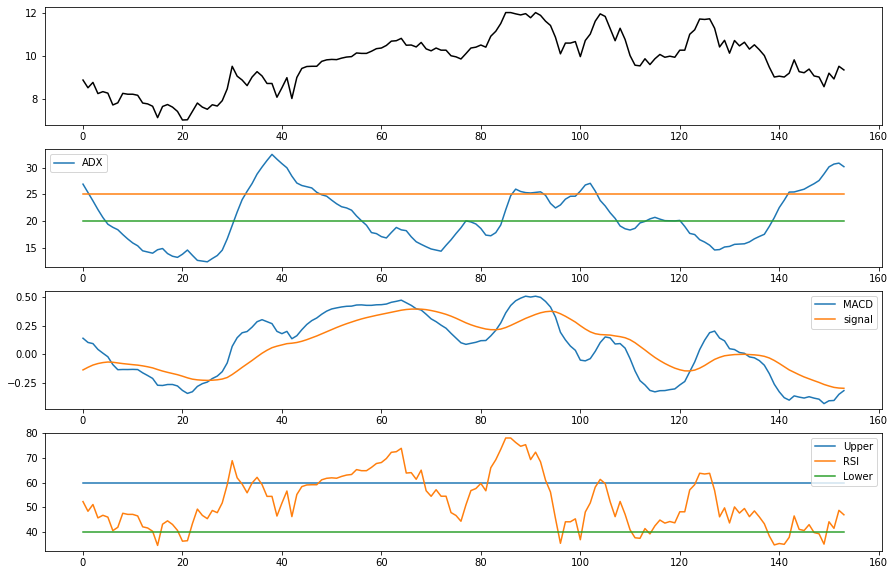

In [12]:
# Plot do gráfico da modelagem | Agrogalaxy
fig, ax = plt.subplots(4, 1, figsize=(15,10));

tam = 1000

ax[0].plot(model.prices[-tam:], color='black');
ax[1].plot(model.indicator1[-tam:]);
ax[1].legend(['ADX']);
ax[2].plot(model.indicator2[-tam:]);
ax[2].legend(['MACD', 'signal']);
ax[3].plot(model.indicator3[-tam:]);
ax[3].legend(['Upper', 'RSI', 'Lower']);

In [13]:
#Aplicação do modelo para a empresa Boa Safra
model = MyStrategy()
print(evaluateHist(model, {'SOJA3.SA': 'SOJA3.SA.csv'}))

Number of trades: 9
Gross P&L: 7.81
Gross Accumulated return: 6.02%
Gross Average Return: 5.86%
Net P&L: 7.81
Hitting ratio: 77.78%
Max Profit: 2.29
Max Drawdown: -0.85



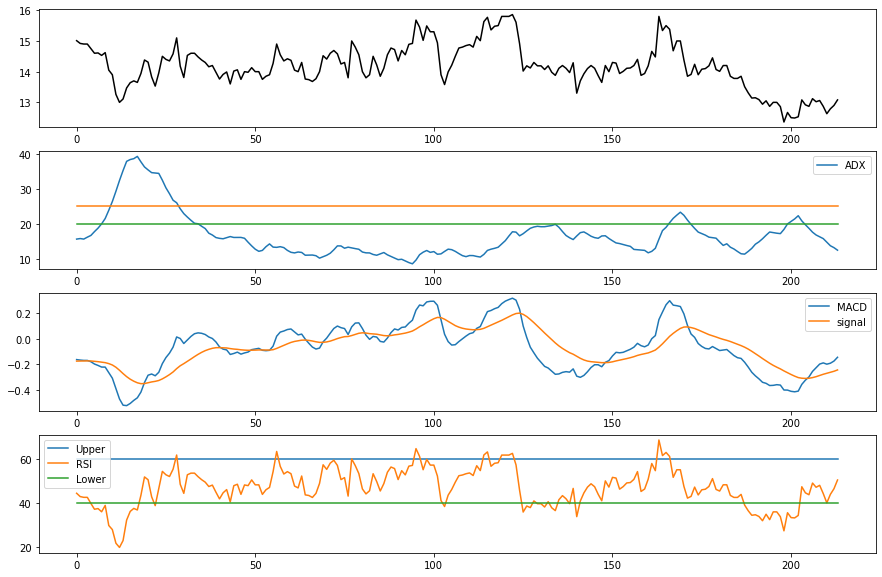

In [14]:
# Plot do gráfico da modelagem | Boa Safra
fig, ax = plt.subplots(4, 1, figsize=(15,10));

tam = 1000

ax[0].plot(model.prices[-tam:], color='black');
ax[1].plot(model.indicator1[-tam:]);
ax[1].legend(['ADX']);
ax[2].plot(model.indicator2[-tam:]);
ax[2].legend(['MACD', 'signal']);
ax[3].plot(model.indicator3[-tam:]);
ax[3].legend(['Upper', 'RSI', 'Lower']);